In [1]:
import mne
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
import joblib
from scipy.signal import welch
from scipy.stats import skew, kurtosis
import pywt
from sklearn.decomposition import PCA

# Data direction
data_dir = 'data_competition/total'

In [2]:
labels_df = pd.read_csv(os.path.join(data_dir,'filtered_subjects_with_age.tsv'), sep='\t')

# Rename participant_id to subject
labels_df = labels_df.rename(columns={'participant_id':'subject'})

# Remove 'sub-' prefix from subject column
labels_df['subject'] = labels_df['subject'].str.replace('sub-', '', regex=False)

# Checking
print(labels_df)

      subject  age
0    CC110033   24
1    CC110037   18
2    CC110045   24
3    CC110056   22
4    CC110069   28
..        ...  ...
155  CC721704   82
156  CC721891   83
157  CC721894   80
158  CC722542   79
159  CC723395   86

[160 rows x 2 columns]


In [3]:
def extract_wavelet_features(data, sfreq, wavelet='db4', level=5, feature_dim=200):
    """
    Extract wavelet transform features from EEG data
    Args:
        data (np.ndarray): EEG data (channels x time).
        sfreq (float): Sampling frequency.
        wavelet (str): Wavelet name.
        level (int): Decomposition level.
        feature_dim: Limit feature dimension for output
    Returns:
        np.ndarray: Wavelet features (channels x scales x coeffs).
    """
    coeffs = pywt.wavedec(data, wavelet=wavelet, level=level, axis = 0)
    wavelet_features = np.concatenate(coeffs)
    wavelet_features = wavelet_features[:feature_dim] if wavelet_features.shape[0] > feature_dim else np.pad(wavelet_features, (0, feature_dim - wavelet_features.shape[0]), 'constant')
    return wavelet_features

# Function to load EEG data and extract features
def load_eeg_data_and_extract_features(file_path, feature_type="wavelet", feature_dim=200):
    raw = mne.io.read_raw_fif(file_path, preload=True)
    misc_channels = raw.copy().pick_types(misc=True)
    data = misc_channels.get_data()
    sfreq = raw.info['sfreq']
    wavelet_features = []
    for channel in data:
        features = extract_wavelet_features(channel, sfreq, feature_dim=feature_dim)
        wavelet_features.append(features)

    return np.array(wavelet_features).flatten()

# Function to get the subject ID from file name
def get_subject_id(file_name):
    return file_name.split('-')[1].split('_')[0]

In [4]:
# Load all data
all_features_wavelet = []
all_subjects = []
for filename in os.listdir(data_dir):
    if filename.endswith('.fif'):
        file_path = os.path.join(data_dir, filename)
        features_wavelet = load_eeg_data_and_extract_features(file_path, feature_type="wavelet")
        subject_id = get_subject_id(filename)
        all_features_wavelet.append(features_wavelet)
        all_subjects.append(subject_id)
        
all_features_wavelet = np.array(all_features_wavelet)
all_subjects = np.array(all_subjects)

# Convert into df
features_df_wavelet = pd.DataFrame({'subject': all_subjects, 'features': list(all_features_wavelet)})

print("features_df_wavelet head:")
print(features_df_wavelet.head())

# Merge with labels dataframe
merged_df_wavelet = pd.merge(features_df_wavelet, labels_df, on='subject')

Opening raw data file data_competition/total\sub-CC110033_sflip_parc-raw.fif...
    Range : 16750 ... 160249 =     67.000 ...   640.996 secs
Ready.
Reading 0 ... 143499  =      0.000 ...   573.996 secs...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Opening raw data file data_competition/total\sub-CC110037_sflip_parc-raw.fif...
    Range : 5000 ... 145499 =     20.000 ...   581.996 secs
Ready.
Reading 0 ... 140499  =      0.000 ...   561.996 secs...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Opening raw data file data_competition/total\sub-CC110045_sflip_parc-raw.fif...
    Range : 24000 ... 164499 =     96.000 ...   657.996 secs
Ready.
Reading 0 ... 140499  =      0.000 ...   561.996 secs...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Opening raw data file data_competition/total\sub-CC110056_sflip_parc-raw.fif...
    Range : 3750 ... 143999 =     15.000 ...   575.996 secs
Ready.
Reading 

In [5]:
# Prepare train and test dataset for Wavelet
subjects_wavelet = merged_df_wavelet['subject'].tolist()
labels_wavelet = merged_df_wavelet['age'].tolist()
features_wavelet = np.array(merged_df_wavelet['features'].tolist())

# Randomly select 40 subjects for testing (Wavelet)
np.random.seed(42)
test_size = 40
test_indices_wavelet = np.random.choice(len(subjects_wavelet), test_size, replace=False)

train_indices_wavelet = [i for i in range(len(subjects_wavelet)) if i not in test_indices_wavelet]

X_train_wavelet = features_wavelet[train_indices_wavelet]
y_train_wavelet = np.array(labels_wavelet)[train_indices_wavelet]
X_test_wavelet = features_wavelet[test_indices_wavelet]
y_test_wavelet = np.array(labels_wavelet)[test_indices_wavelet]

# Shape checking
print("Shape of X_train:", X_train_wavelet.shape)
print("Shape of y_train:", y_train_wavelet.shape)
print("Shape of X_test:", X_test_wavelet.shape)
print("Shape of y_test:", y_test_wavelet.shape)

# Scale the features before PCA for Wavelet
scaler_wavelet = StandardScaler()
X_train_scaled_wavelet = scaler_wavelet.fit_transform(X_train_wavelet)
X_test_scaled_wavelet = scaler_wavelet.transform(X_test_wavelet)

# Apply PCA for Wavelet (We can use PCA or not)
pca_wavelet = PCA(n_components=0.99)
X_train_pca_wavelet = pca_wavelet.fit_transform(X_train_scaled_wavelet)
X_test_pca_wavelet = pca_wavelet.transform(X_test_scaled_wavelet)

Shape of X_train: (120, 10400)
Shape of y_train: (120,)
Shape of X_test: (40, 10400)
Shape of y_test: (40,)


In [6]:
# Random Forest for Wavelet
rf_model_wavelet = RandomForestRegressor(n_estimators=500, random_state=42)
rf_model_wavelet.fit(X_train_scaled_wavelet, y_train_wavelet)

y_pred_rf_wavelet = rf_model_wavelet.predict(X_test_scaled_wavelet)

# Compute metrics for Wavelet
mae_rf_wavelet = mean_absolute_error(y_test_wavelet, y_pred_rf_wavelet)
print(f"Random Forest MAE (Wavelet): {mae_rf_wavelet:.2f} years")

mse_rf_wavelet = mean_squared_error(y_test_wavelet, y_pred_rf_wavelet)
print(f"Random Forest MSE (Wavelet): {mse_rf_wavelet:.2f}")

r2_rf_wavelet = r2_score(y_test_wavelet, y_pred_rf_wavelet)
print(f"Random Forest R2 (Wavelet): {r2_rf_wavelet:.2f}")

Random Forest MAE (Wavelet): 16.29 years
Random Forest MSE (Wavelet): 389.06
Random Forest R2 (Wavelet): 0.01


In [10]:
# SVR for Wavelet
svr_model_wavelet = SVR(C=10, gamma=10, kernel='rbf')
svr_model_wavelet.fit(X_train_scaled_wavelet, y_train_wavelet)

y_pred_svr_wavelet = svr_model_wavelet.predict(X_test_scaled_wavelet)

# Compute metrics for Wavelet
mae_svr_wavelet = mean_absolute_error(y_test_wavelet, y_pred_svr_wavelet)
print(f"SVR MAE (Wavelet): {mae_svr_wavelet:.2f} years")

mse_svr_wavelet = mean_squared_error(y_test_wavelet, y_pred_svr_wavelet)
print(f"SVR MSE (Wavelet): {mse_svr_wavelet:.2f}")

r2_svr_wavelet = r2_score(y_test_wavelet, y_pred_svr_wavelet)
print(f"SVR R2 (Wavelet): {r2_svr_wavelet:.2f}")

SVR MAE (Wavelet): 16.98 years
SVR MSE (Wavelet): 392.58
SVR R2 (Wavelet): -0.00


In [19]:
# XGBoost for Wavelet
xgb_model_wavelet = XGBRegressor(n_estimators=100, learning_rate=0.01, max_depth=3, random_state=42)
xgb_model_wavelet.fit(X_train_scaled_wavelet, y_train_wavelet)

y_pred_xgb_wavelet = xgb_model_wavelet.predict(X_test_scaled_wavelet)

# Compute metrics for Wavelet
mae_xgb_wavelet = mean_absolute_error(y_test_wavelet, y_pred_xgb_wavelet)
print(f"XGBoost MAE (Wavelet): {mae_xgb_wavelet:.2f} years")

mse_xgb_wavelet = mean_squared_error(y_test_wavelet, y_pred_xgb_wavelet)
print(f"XGBoost MSE (Wavelet): {mse_xgb_wavelet:.2f}")

r2_xgb_wavelet = r2_score(y_test_wavelet, y_pred_xgb_wavelet)
print(f"XGBoost R2 (Wavelet): {r2_xgb_wavelet:.2f}")

XGBoost MAE (Wavelet): 16.79 years
XGBoost MSE (Wavelet): 383.89
XGBoost R2 (Wavelet): 0.02


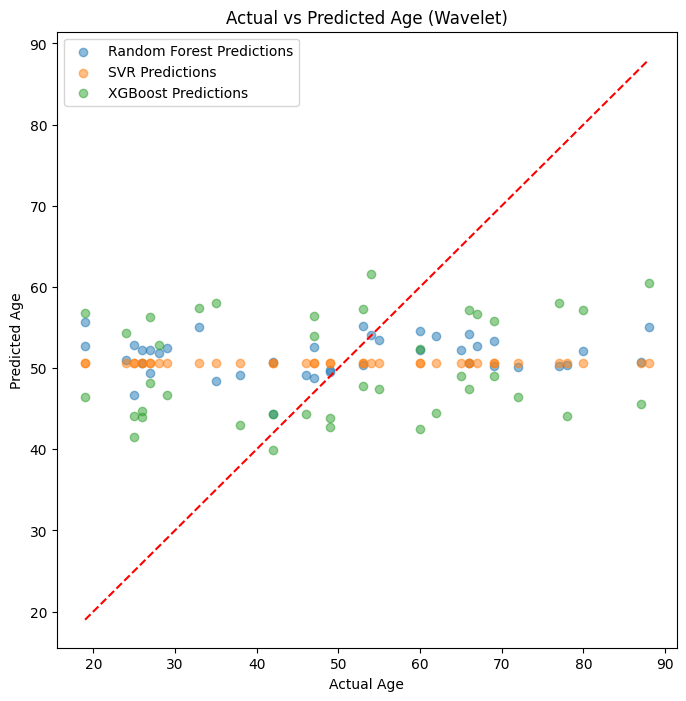

In [20]:
# Visualize the predictions against actual values
plt.figure(figsize=(8, 8))
plt.scatter(y_test_wavelet, y_pred_rf_wavelet, label='Random Forest Predictions', alpha=0.5)
plt.scatter(y_test_wavelet, y_pred_svr_wavelet, label='SVR Predictions', alpha=0.5)
plt.scatter(y_test_wavelet, y_pred_xgb_wavelet, label='XGBoost Predictions', alpha=0.5)
plt.plot([min(y_test_wavelet), max(y_test_wavelet)], [min(y_test_wavelet), max(y_test_wavelet)], color='red', linestyle='--')  # Line of perfect prediction
plt.xlabel("Actual Age")
plt.ylabel("Predicted Age")
plt.title("Actual vs Predicted Age (Wavelet)")
plt.legend()
plt.show()